# Pseudo Labeling

> Pseudo Labeling basics for Noise Reduction and Data Creation

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Deep Learning]

# Intro

**Goal:** The goal of this article is to provide an understanding of what pseudo labeling is, why you might use it, and how you would go about using it.

**What's Included in this post:** The information needed to get **started** on pseudo labeling on your project.

# What is pseudo labeling

**Pseudo Labeling** is the process of creating new labels for a piece of data.

The general idea can be broken into a few steps:
1. Create a model
1. Make predictions on some data with that model
1. Pretend all (or some) of those predictions are ground truth label
1. Train a new model with those predictions

We will get into more of the details in the how-to section!

# Why would I use pseudo labeling?

There are two main functions pseudo Labeling can be used for.  I will step through each and provide a general 

## Data Cleaning & Noise Reduction

Imagine you have a dataset and all the samples have been hand labeled.  You know they can't all be labeled appropriately because it was manual labeling and you want to improve your labels.  You have a few options:

1. Go through every datapoint again and manually verify them all
1. Somehow identify the ones that are likely to be wrong and put more focus on those ones.

Pseudo labeling can help with option number 2.  By creating a prediction on a datapoint, you can see which labels the model disagrees with.  Even better, you can look at the confidence that model has in the prediction.  So by looking at datapoints that the model is confident are wrong, you can really narrow your focus on your problem areas quickly.

You then can fix it in 2 ways:
1. Replace your labels with the predicted labels following some threshold (ie score of .9 or higher).
1. Manually re-classify these labels if you have the time and domain expertise to do these.

## Data Augmentation

This approach can also be used on unlabeled data.  Rather than trying to replace bad labels, this approach focuses on creating labels for unlabeled data.  This can be used on a kaggle test set for example.  The reason this can work is because you are teaching the model the structure of the data.  Even if not all labels are correct, a lot can still be learning.

Think about if you were to learn what a new type of object looks like.  Maybe a type of furniture you'd never heard of before.  Doing a google image search for that name and looking at all the results is really helpful, even if not all of the images that are shown are all correct.

>Note:  I found out about this Approach from Jeremy Howard.  He speaks on this in an old version of the fastai course.  [Here](https://medium.com/deep-learning-journals/faster-ai-lesson-4-tl-dr-version-of-fast-ai-part-1-70124cacd560) is  a summary that includes a link to the portion of the old course he discusses this approach in.  I would highly reccomend checking out the latest course as well [here](https://course.fast.ai/).

# How to use pseudo labeling (Noise Reduction)

I will use the validation set for this example because it is a little bit more involved.  You can simplify this approach a bit if you are doing this on unlabeled data.

## Imports

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST,force_download=True)
from sklearn.model_selection import StratifiedKFold
from numpy.random import default_rng

## Introduce Noise to Data

In [2]:
x = get_image_files(path)
y = L(parent_label(o) for o in get_image_files(path))

Get 10% of the indexes to randomly change

In [3]:
n = len(x)
rng = default_rng()

noise_idxs = rng.choice(n, size=round(n*0.1), replace=False)
len(noise_idxs),noise_idxs[:5]

(7000, array([17419, 48844, 61590, 49810, 26348]))

Randomly change these so we have some bad labels

In [4]:
for i in range(0,len(noise_idxs)):
    old_path = str(x[noise_idxs[i]])
                     
    if 'training' in old_path:
        new_path = str(x[noise_idxs[i]])[:49]+f'{np.random.randint(0,10)}'+str(x[noise_idxs[i]])[50:]
    elif 'testing' in old_path:
        new_path = str(x[noise_idxs[i]])[:48]+f'{np.random.randint(0,10)}'+str(x[noise_idxs[i]])[49:]
        
    os.system(f'mv {old_path} {new_path}')


## Look at Data

Some of our labels are now misclassified, but we don't know which ones.  We could look at every image to find them, but that would take a ton of time.  Let's try to find the misclassified images and correct them using a pseudo labeling approach.

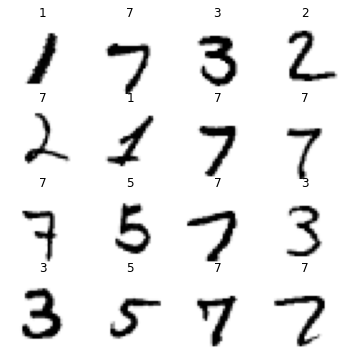

In [31]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=RandomSplitter(),
                  get_y=parent_label)
dls = mnist.dataloaders(path,bs=16)
dls.show_batch(max_n=36,figsize=(6,6))

## Create Crossfold, Train, and Predict

This step is much simpler if you are generating labels for the test set, as you would train your model as normal and predict as normal.  The reason I am doing cross folds is to get predicted labels on the training set.

>Note:  I am doing this with a 2 fold, but you may want to use a 5-fold or more folds.

This cross-fold code was mostly supplied by [Zach Mueller](https://twitter.com/TheZachMueller), with minor modifications by me for this dataset and tutorial.  There is also a tutorial he wrote with more details [here](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/03_Cross_Validation.ipynb)

In [6]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
splits, preds, targs, preds_c, items = [],[],[],[], []

for _, val_idx in skf.split(x,y):
    splitter = IndexSplitter(val_idx)
    splits.append(val_idx)

    mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                      get_items=get_image_files, 
                      splitter=splitter,
                      get_y=parent_label)

    dls = mnist.dataloaders(path,bs=16)
    learn = cnn_learner(dls,resnet18,metrics=accuracy)
    learn.fine_tune(2,reset_opt=True)
    
    # store predictions
    p, t, c = learn.get_preds(ds_idx=1,with_decoded=True)
    preds.append(p); targs.append(t); preds_c.append(c); items.append(dls.valid.items)

## Look at Predictions

Lets throw it all in a dataframe so we can look at what we have a little easier.  First, let's break out our differnt pieces of information.

In [7]:
items_flat = L(itertools.chain.from_iterable(items))
imgs = L(o for o in items_flat)
y_true = L(int(parent_label(o)) for o in items_flat) # Labels from dataset
y_targ = L(int(o) for o in torch.cat(targs)) # Labels from out predictions
y_pred = L(int(o) for o in torch.cat(preds_c)) # predicted labels or "pseudo labels"
p_max = torch.cat(preds).max(dim=1)[0] # max model score for row

We can double check we are matching things upp correctly by checking that the labels line up from the predictions and the original data.  Throwing some simple assert statements in is nice because it takes no time and it will let you know if you screw something up later as you are tinkering with things.

In [8]:
assert (y_true == y_targ) # test we matched these up correct

Put it in a dataframe and see what we have.

In [9]:
res = pd.DataFrame({'imgs':imgs,'y_true':y_true,'y_pred':y_pred,'p_max':p_max})
res.head(5)

imgs  y_true  y_pred  \
0  /home/isaacflath/.fastai/data/mnist_png/testing/1/8418.png       1       1   
1  /home/isaacflath/.fastai/data/mnist_png/testing/1/2888.png       1       7   
2  /home/isaacflath/.fastai/data/mnist_png/testing/1/6482.png       1       1   
3  /home/isaacflath/.fastai/data/mnist_png/testing/1/7582.png       1       1   
4  /home/isaacflath/.fastai/data/mnist_png/testing/1/4232.png       1       1   

      p_max  
0  0.864995  
1  0.900654  
2  0.906335  
3  0.902999  
4  0.925955

Perfect so lets get a list of our images our model got 'wrong' and grab some random ones out of the top 5000 the model was most confident about.  The theory is that many of these may be misclassified, and we can reclassify them either using the predicted 'pseudo' labels, or with manual classification.

In [24]:
imgs = res[res.y_true != res.y_pred].sort_values('p_max',ascending=False)[:5000].sample(frac=1)

And then we plot them and see our predicted labels of these are WAY better than the actual labels.  A great way to identify some bad labels.

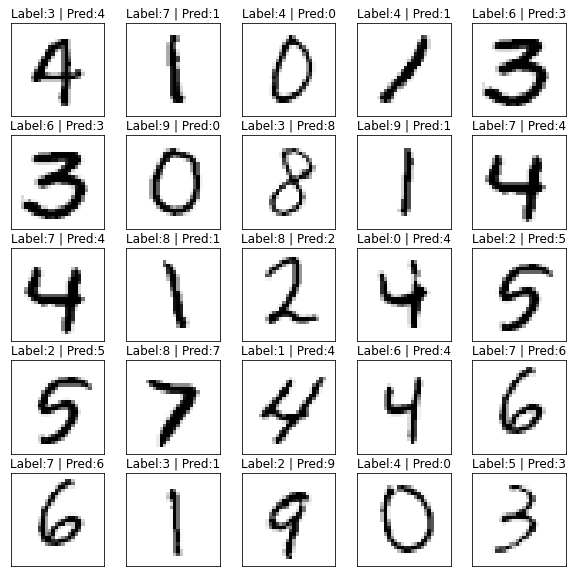

In [27]:
%matplotlib inline
fig, ax = plt.subplots(5,5,figsize=(10,10))

for row in range(0,5):
    for col in range(0,5):
        img_path1 = imgs.iloc[row*4+col,0]
        img_path1 = np.array(Image.open(img_path1))
        ax[row,col].imshow(img_path1,cmap='Greys')
        ax[row,col].set_title(f'Label:{parent_label(imgs.iloc[row*4+col,0])} | Pred:{imgs.iloc[row*4+col,2]}')
        ax[row,col].get_xaxis().set_visible(False)
        ax[row,col].get_yaxis().set_visible(False)

## What Next?

Now that we have found mislabeled data, we can fix them.  We see that in this problem in the top 5000 most confident wrong answers our predicted labels are much better.

So the next step would be to replace the labels with our predicted labels, then train our model on the newly cleaned labels!

>Note:  This same approach can be used on unlabeled data to get data points the model is confident in to expand the training data.